# EDA - Understanding Email Campaign Data

This notebook is dedicated to exploring the email/clicks data so that we can:
* Consider what types of ML algorithms would do well on this sort of data (lots of categorical data, discrete numeric data, no continuous data except subject hotness which is borderline discrete)
* Be familiar with data structure and format
* Find inconsistencies and opportunities for data preprocessing/engineering including missingness, invalid data, and decisions on transformations
* Identify class imbalances
* Discover relationships between features, both categorical and numeric, in addition to the target
    * In the ML notebook we will use statistical tests to formalize this for feature selection
* Gain intuition for potential interactions and feature importances
* Discover and visualize opportunities for recommendations outside of the ML setting, in particular how to design more effective marketing emails that align with higher click probabilities

Some noteworthy results:
* Not all features show a relationship to click result, in particular Location, Source Type, Send Time, and Images are not particularly relevant
* Class imbalance of 80/20, which is not too extreme but will limit predictive capability
    * 20% click rate I would imagine is unbelievably good in a real world setting but for the sake of this project we can assume we need to improve
* Very few cohorts are strongly predictive of click result, less than 50% in the best case. This will pose a challenge during modeling, but not unusual.
* The real bottomline here is use fewer words, be aware of how Campaign 2 interacts with other features like word count and subject hotness, and try to build your customer base as much as you can (ie you want people who are willing to receive a lot of emails because they are likely returning customers)
* Some particularly important interactions include:
    * `Total_Past_Communications` + `Subject_Hotness_Score`
    * `Subject_Hotness_Score` + `Word_Count`
    * `Total_Past_Communications` + `Word_Count`
    * `Email_Campaign_Type` + `Total_Past_Communications` and`Total_Link` and `Total_Image`

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Load data
camp_df = pd.read_csv('data/email_camp_data.csv')
camp_df["Email_Type"] = pd.Categorical(camp_df["Email_Type"])
camp_df["Email_Source_Type"] = pd.Categorical(camp_df["Email_Source_Type"])
camp_df["Customer_Location"] = pd.Categorical(camp_df["Customer_Location"])
camp_df["Email_Campaign_Type"] = pd.Categorical(camp_df["Email_Campaign_Type"])
camp_df["Time_Email_sent_Category"] = pd.Categorical(camp_df["Time_Email_sent_Category"])
camp_df["Word_Count"] = camp_df["Word_Count"].astype(float)
# camp_df["Email_Status"] = pd.Categorical(camp_df["Email_Status"])

camp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68353 entries, 0 to 68352
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Email_ID                   68353 non-null  object  
 1   Email_Type                 68353 non-null  category
 2   Subject_Hotness_Score      68353 non-null  float64 
 3   Email_Source_Type          68353 non-null  category
 4   Customer_Location          56758 non-null  category
 5   Email_Campaign_Type        68353 non-null  category
 6   Total_Past_Communications  61528 non-null  float64 
 7   Time_Email_sent_Category   68353 non-null  category
 8   Word_Count                 68353 non-null  float64 
 9   Total_Links                66152 non-null  float64 
 10  Total_Images               66676 non-null  float64 
 11  Email_Status               68353 non-null  int64   
dtypes: category(5), float64(5), int64(1), object(1)
memory usage: 4.0+ MB


First we need to split our data into test and train. Even for exploration we should only look at training data. We see that the response is evenly distributed for out test and training set.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    camp_df.drop(columns = ['Email_Status','Email_ID']), camp_df["Email_Status"], test_size=0.2, random_state=23, stratify=camp_df["Email_Status"])


In [5]:
# Imbalanced response, key for ML
y_train.value_counts(normalize=True)

Email_Status
0    0.803775
1    0.196225
Name: proportion, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

Email_Status
0    0.803818
1    0.196182
Name: proportion, dtype: float64

In [7]:
XY_train = pd.concat([X_train,y_train],axis=1)
XY_train

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
14527,1,0.2,2,D,3,NaN,3,700.0,18.0,12.0,0
30487,1,2.5,2,G,2,14.0,2,636.0,4.0,3.0,0
21040,2,0.4,1,E,2,38.0,2,778.0,2.0,0.0,0
16352,2,0.2,1,E,3,25.0,1,778.0,9.0,0.0,0
15436,1,0.0,1,G,3,45.0,2,636.0,21.0,12.0,1
...,...,...,...,...,...,...,...,...,...,...,...
60625,1,0.2,1,G,3,30.0,2,636.0,21.0,19.0,0
54805,2,0.1,1,E,3,29.0,2,721.0,3.0,0.0,0
22595,2,0.3,1,G,3,14.0,2,524.0,9.0,0.0,0
42562,2,0.5,1,NaN,2,NaN,1,694.0,5.0,0.0,0


In [8]:
# Confirm email id doesn't have duplicates
camp_df["Email_ID"].value_counts().head()

Email_ID
EMA00081000034500    1
EMA00085070036390    1
EMA00085069142230    1
EMA00085069365610    1
EMA00085069446970    1
Name: count, dtype: int64

## Missing Values
4 fields with missing values. We should consider whether imputation is appropriate or not for these records. 
* Customer Location
    * This field is missing for a lot of records. This could be because the user did not grant permission for location to be tracked. 
    * An appropriate measure here is to just label them as 'Unknown'
* Total Past Communications, Total Links, Total Images
    * It is not readily apparent why these records have missing values. Cross referencing against counts and distibutions of other fields we see similar behavior regardless of missingness. 
    * 0's (or 1's for Total Links) exist in the data so we shouldn't interpret it as meaning 0 or the minimum possible value. 
    * We don't have any information to suggest these records are invalid either so imputation would be a good approach during feature engineering in ML workflow.

In [9]:
# Fields with missing values
# 1 categorical: Customer Location
# 3 numerical fields: Total_Past_Communications, Total_Links, Total_Images
XY_train.isna().sum()

Email_Type                      0
Subject_Hotness_Score           0
Email_Source_Type               0
Customer_Location            9231
Email_Campaign_Type             0
Total_Past_Communications    5437
Time_Email_sent_Category        0
Word_Count                      0
Total_Links                  1748
Total_Images                 1323
Email_Status                    0
dtype: int64

The loop will give us count plots for each combination of categorical with no missing values (`cat`) and all of the fields with missing values (`miss`) which we will transform into a binary indicating missingness. 
* This will help us see if the missingness is over-represented in any category, potentially exposing a relationship we should investigate.
* At first glance, there does not seem to be a connection between these categories and the missingness of the fields

In [ ]:
for cat in ['Email_Type','Email_Source_Type','Email_Campaign_Type','Time_Email_sent_Category']:
    for miss in ['Total_Past_Communications','Total_Links','Total_Images','Customer_Location']:
        sns.catplot(data=XY_train,hue=cat,x=XY_train[miss].isna(),kind='count')
        plt.show()

Instead of using categoricals, we can use the distributions of the numerics that don't have missing values. If the shapes of their distributions, or their summary statistics more generally, are markedly different then we may have something to investigate.
* Distributions are nearly identical across numerics for both missing/not missing groups

In [ ]:
for num in ['Subject_Hotness_Score','Word_Count']:
    for miss in ['Total_Past_Communications','Total_Links','Total_Images','Customer_Location']:
        sns.displot(data=XY_train,x=num,col=XY_train[miss].isna(),bins=20,facet_kws={'sharey':False})
        plt.show()

We can quickly fill in the NA's for the customer location for the sake of data visualization. Will use a more robust approach during model data preprocessing. We won't impute numerics for visualization as it likely won't make a noticeable difference.

In [12]:
XY_train["Customer_Location"] = np.where(XY_train["Customer_Location"].isna(),"Unknown",XY_train["Customer_Location"])

## Checking for Invalid Records
Doesn't seem like any of the records are invalid (for instance if any of these features were < 0)

In [13]:
num_feat_df = XY_train[['Subject_Hotness_Score','Total_Past_Communications','Word_Count','Total_Links','Total_Images']].copy()
num_feat_df.describe()

,Subject_Hotness_Score,Total_Past_Communications,Word_Count,Total_Links,Total_Images
count,54682.000000,49245.000000,54682.000000,52934.000000,53359.000000
mean,1.094830,28.961641,699.018854,10.415064,3.540546
std,0.998465,12.526110,271.473690,6.382093,5.610932
min,0.000000,0.000000,40.000000,1.000000,0.000000
25%,0.200000,20.000000,521.000000,6.000000,0.000000
50%,0.800000,28.000000,694.000000,9.000000,0.000000
75%,1.800000,38.000000,880.000000,14.000000,5.000000
max,5.000000,67.000000,1316.000000,49.000000,45.000000


## Click Rate and Univariate numeric features

I will bin our numerics since they all are count metrics. This makes visualization convenient.

If we bin our numeric features and measure the probability of clicking, we get a nuanced feel for how click decision can vary as the feature value increases
* Subject Hotness follows a U-shape. This means that when the subject is very plain and when it is extra spicy we observe higher click rates. Being in the middle doesn't help at all. In fact, it performs worse than the population probability of 19%.
* Past communications follows a skewed U-shape. If someone is a brand-new recepient then they are likely to click. Otherwise, there is a steep climb to higher probabilities as the accumulation of emails increases. This makes sense since new people may have signed up and so they're ready to click, or they are curious about what the email is about in the case where they didn't subscribe. For those who have received more emails these are could be very loyal customers who interact with our campaigns regularly historically.
* Word count within the email has a very clean trend. The shorter the better. This one makes sense. Attention spans are short.
* Links and images don't stand out as being particularly predictive, but moreso is this true for images who are skewed heavily towards 0 images.

We will want to dive into these even more to understand how they relate to one another, how the features are distributed, and then how categoricals come into the picture.

In [14]:
# def calc_prob_success(df, numeric_feature, target, bin_size):
#     # Determine the minimum and maximum values of the feature
#     min_value = df[numeric_feature].min()
#     max_value = df[numeric_feature].max()
    
#     # Create bins based on the bin size (width of each bin)
#     bin_edges = np.arange(min_value, max_value + bin_size, bin_size)
    
#     # Create the bins, including the lowest value in the first bin
#     df['bin'] = pd.cut(df[numeric_feature], bins=bin_edges, include_lowest=True, right=False)
    
#     prob_table = df.groupby('bin',observed=True).agg(
#         probability_of_success=(target, 'mean'),
#         sample_size=(target, 'size')
#     ).reset_index()
    
#     # Rename the columns for clarity
#     prob_table.columns = [f'{numeric_feature}_bin', 'probability_of_success', 'sample_size']
    
#     # Create the bar plot with sample sizes
#     g = sns.catplot(prob_table, x=f'{numeric_feature}_bin', y='probability_of_success', kind='bar', aspect=1.5)
    
#     # Add sample size annotations
#     for i, row in prob_table.iterrows():
#         g.ax.text(i, row['probability_of_success'] + 0.01, f'n={row["sample_size"]}', 
#                   ha='center', va='bottom', fontsize=10, color='black')
#     plt.xticks(rotation=45)
    
#     # Show the plot
#     plt.show()
    
#     return prob_table

In [15]:
bin_edges_dict = {
    'Subject_Hotness_Score': [0,1,2,3,4,5],
    'Total_Past_Communications': [0,1,20,30,40,50,np.inf],
    'Word_Count': [0,100,200,300,400,500,600,700,800,900,1000,np.inf],
    'Total_Links': [1,2,5,7,10,15,20,50,np.inf],
    'Total_Images': [0,1,3,5,7,10,np.inf]
}

In [16]:
for key,val in bin_edges_dict.items():
    XY_train[key + '_Bin'] = pd.cut(XY_train[key],bins=val,right=False)

In [17]:
def calc_prob_success(df, numeric_feature):
    
    prob_table = df.groupby(numeric_feature,observed=True).agg(
        probability_of_success=("Email_Status", 'mean'),
        sample_size=("Email_Status", 'size')
    ).reset_index()
    
    # Rename the columns for clarity
    prob_table.columns = [numeric_feature, 'probability_of_success', 'sample_size']
    
    # Create the bar plot with sample sizes
    g = sns.catplot(prob_table, x=numeric_feature, y='probability_of_success', kind='bar', aspect=1.5)
    
    # Add sample size annotations
    for i, row in prob_table.iterrows():
        g.ax.text(i, row['probability_of_success'] + 0.01, f'n={row["sample_size"]}', 
                  ha='center', va='bottom', fontsize=10, color='black')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()
    
    return prob_table

In [18]:
# XY_train['Hotness_Binary'] = (XY_train['Subject_Hotness_Score'] < 1) | (XY_train["Subject_Hotness_Score"] >= 4)
# XY_train['PastComm_Bins']

In [55]:
XY_train[XY_train["Word_Count"] > 600]

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status,Subject_Hotness_Score_Bin,Total_Past_Communications_Bin,Word_Count_Bin,Total_Links_Bin,Total_Images_Bin
14527,1,0.2,2,D,3,NaN,3,700.0,18.0,12.0,0,"[0, 1)",NaN,"[700.0, 800.0)","[15.0, 20.0)","[10.0, inf)"
30487,1,2.5,2,G,2,14.0,2,636.0,4.0,3.0,0,"[2, 3)","[1.0, 20.0)","[600.0, 700.0)","[2.0, 5.0)","[3.0, 5.0)"
21040,2,0.4,1,E,2,38.0,2,778.0,2.0,0.0,0,"[0, 1)","[30.0, 40.0)","[700.0, 800.0)","[2.0, 5.0)","[0.0, 1.0)"
16352,2,0.2,1,E,3,25.0,1,778.0,9.0,0.0,0,"[0, 1)","[20.0, 30.0)","[700.0, 800.0)","[7.0, 10.0)","[0.0, 1.0)"
15436,1,0.0,1,G,3,45.0,2,636.0,21.0,12.0,1,"[0, 1)","[40.0, 50.0)","[600.0, 700.0)","[20.0, 50.0)","[10.0, inf)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,1,1.6,1,G,2,18.0,3,827.0,2.0,0.0,1,"[1, 2)","[1.0, 20.0)","[800.0, 900.0)","[2.0, 5.0)","[0.0, 1.0)"
66988,1,1.3,2,Unknown,2,20.0,2,892.0,2.0,NaN,0,"[1, 2)","[20.0, 30.0)","[800.0, 900.0)","[2.0, 5.0)",NaN
60625,1,0.2,1,G,3,30.0,2,636.0,21.0,19.0,0,"[0, 1)","[30.0, 40.0)","[600.0, 700.0)","[20.0, 50.0)","[10.0, inf)"
54805,2,0.1,1,E,3,29.0,2,721.0,3.0,0.0,0,"[0, 1)","[20.0, 30.0)","[700.0, 800.0)","[2.0, 5.0)","[0.0, 1.0)"


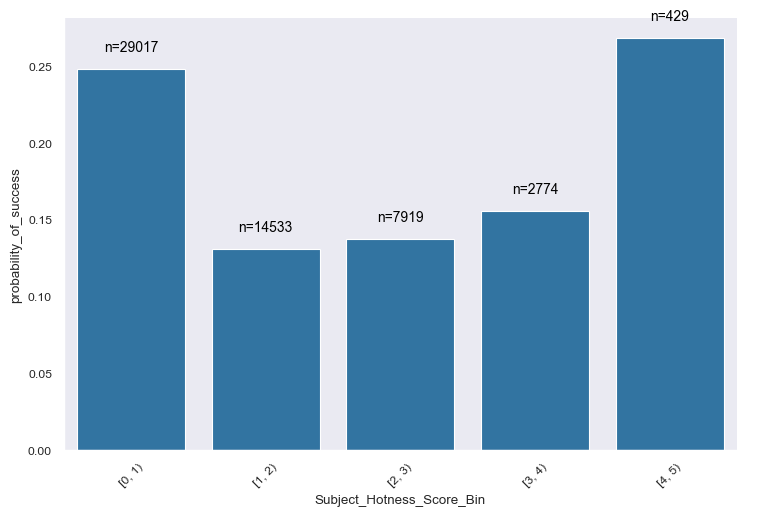

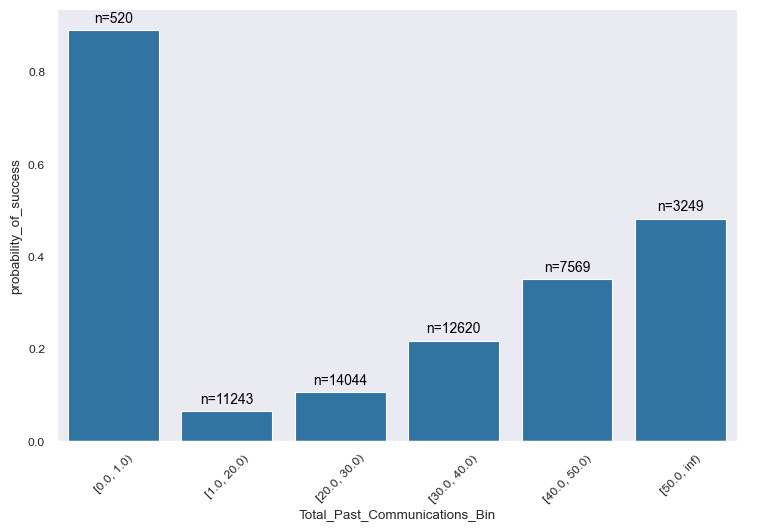

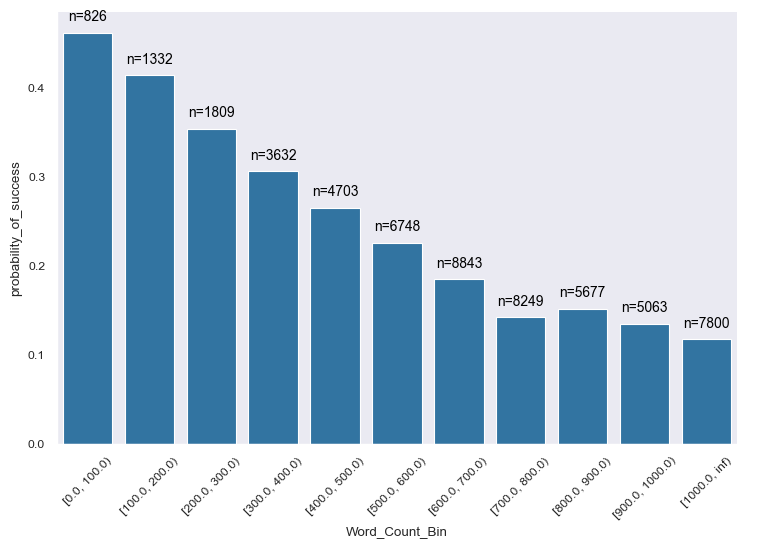

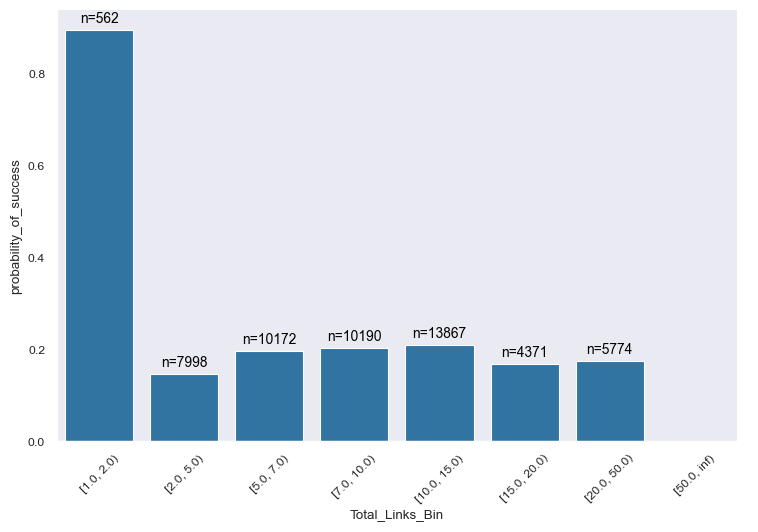

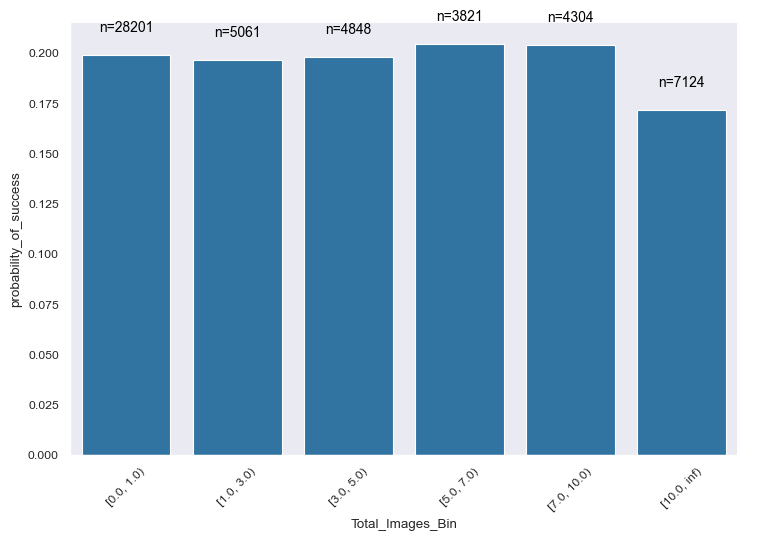

In [56]:
for i in ['Subject_Hotness_Score_Bin',	'Total_Past_Communications_Bin',	'Word_Count_Bin',	'Total_Links_Bin',	'Total_Images_Bin']:
    calc_prob_success(XY_train,i)

## Distributions of univariate numeric features

Let's look just at histograms. At this point we have a good feel for what scenaraios are more likely to result in a click. Let's just get a feel for frequency here because it will matter for feature engineering.

* Data Transformation needs:
    * `Total_Past_Communications`, `Word_Count` are relatively normally distributed. Won't transform these.
    * `Subject_Hotness_Score`, `Total_Images` are right skewed, as well as `Total_Links` but less so. These will require transformation for linear models.

In [ ]:
for i in num_feat_df.columns:
    sns.displot(data=XY_train,x=XY_train[i],col='Email_Status',bins = 17,facet_kws={'sharey':False})

## Relationships between numeric features

* Correlations (Meant to be a rough measurement since this statistic may not be appropriate for all data types/distributions). 
    * Will use more robust feature selection techniques during model preprocessing such as mutual information to determine if interactions should be introduced and VIF for multicolinearity detection.
    * `Total_Links` and `Total_Images` are strongly positively correlated. Not particularly surprising since you may expect images to be embedded with links many times. But good to point out either way.
    * `Subject_Hotness_Score` has some negative correlation with `Word_Count` and even moreso with `Total_Past_Communications` (negative)
        * Negative correlation with `Total_Past_Communications` is interesting because it implies that recepients with a shorter history of receiving emails get more 'hot' subject lines. Could it be that we need a stronger hook for those who perhaps aren't familiar with our brand? Does it work?
        * Negative correlation with `Word_count` is also interesting. This means that as the subject gets hotter, the email has fewer words. Get their attention with the subject, and keep the body short and to the point seems like the strategy.
    * `Word_Count` and `Total_Past_Communications` has some negative correlation
        * Those who have more past communication receive emails with fewer words. This could be a powerful predictive combination since naturally you'd expect those who have received more emails to be loyal customers and that shorter emails would keep people's attention longer.

In [634]:
pd.concat([num_feat_df,XY_train["Email_Status"]],axis=1).corr()

,Subject_Hotness_Score,Total_Past_Communications,Word_Count,Total_Links,Total_Images,Email_Status
Subject_Hotness_Score,1.000000,-0.442653,-0.239015,-0.027962,-0.019119,-0.128683
Total_Past_Communications,-0.442653,1.000000,-0.359985,0.114351,0.064056,0.248671
Word_Count,-0.239015,-0.359985,1.000000,0.071184,0.048344,-0.188246
Total_Links,-0.027962,0.114351,0.071184,1.000000,0.781090,-0.031898
Total_Images,-0.019119,0.064056,0.048344,0.781090,1.000000,-0.023734
Email_Status,-0.128683,0.248671,-0.188246,-0.031898,-0.023734,1.000000


Looking at the scatter plots for all of our pairwise combinations of numerical fields we see some patterns.

* Noteworthy Click Decision Groupings
    * High `Total_Past_Communications` + Low `Subject_Hotness_Score`
        * Still see many clicks as hotness goes up but not as the past communications decrease
    * If the `Subject_Hotness_Score` is low, click decision seems relatively insensitive to the `Word_Count` volume, though there is better representation for under 600 compared to those who don't click
    * `Total_Past_Communications` over 30 does well across the other numerics and is dispersed relatively well. 
    * `Word_Count` has some dispersion, but generally speaking performs better when well less than 1000 words. Click decision seems less sensitive when the past communication is higher though (ie word count can be higher and still get clicks if they've received many emails previously)

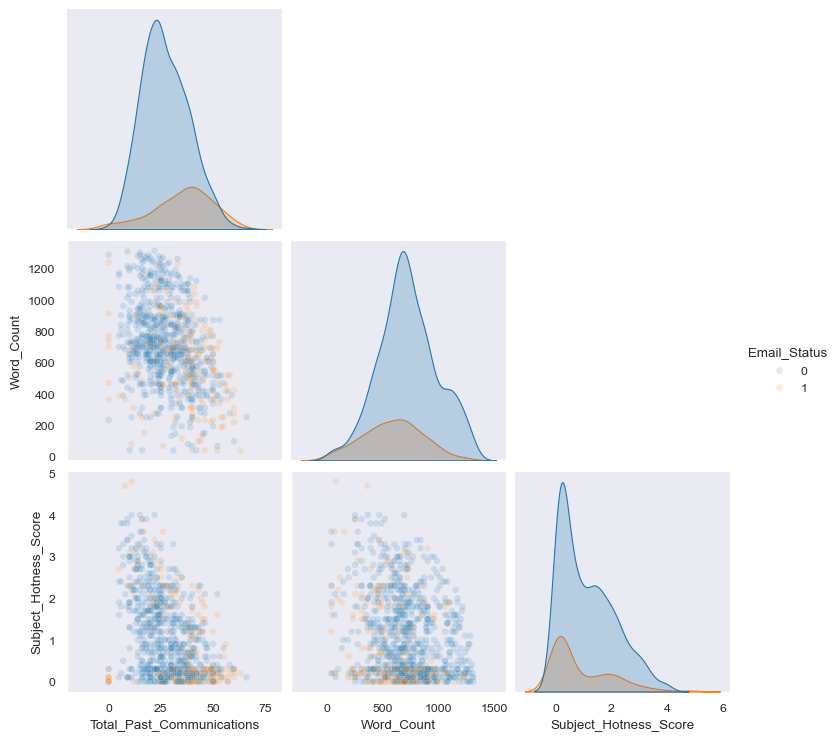

In [43]:
sns.set_style("dark")
sns.set_context("paper")
sns.pairplot(XY_train[['Total_Past_Communications','Word_Count',"Subject_Hotness_Score",'Email_Status']].sample(1000),plot_kws={'alpha':.15},hue="Email_Status", corner=True,hue_order=[0,1],aspect=1)

## Click Rate & Interactive Numeric Features

Let's go back to our probabilities, this time as a heatmap with pairs of other binned numerics, to see if we can tease out these relationships and trends more explicitly in terms of our target

Quick Hits of the most noteworthy combos where some high-level strategy could be gleaned
* `Total_Past_Communications` + `Subject_Hotness_Score`
    * Certainly is true we would want to have recepients have more past communication (other than brand new folks). But it does seem like we make gains across Subject Hotness bins so this is helpful to strategize how to frame our subject lines to different cohorts of recepients.
* `Subject_Hotness_Score` + `Word_Count`
    * Strong interaction. Lower = better for both.
* `Total_Past_Communications` + `Total_Links` 
    * A really important note about those who are brand new is that they will pretty much only click if there is a very small number of links! So need to make sure we are deliberate about that.
    * For those with more history with us, click result does drop off slightly as link count goes up but not egrigiously.
* `Total_Past_Communications` + `Word_Count`
    * Another important note for those who are receiving emails for the first time, they strongly prefer lower word counts. 65% click rate for less than 40 words and then it drops to 53% after adding just 200 words. The sample sizes are somewhat low but the trend seems clear. It stabilizes around 640 words at 20% or so. So far, we've been sending emails way too lengthy for new recepients. 
    * This differs from those who have received emails longer, they are not nearly as sensitive to increases in word counts. 
    * We can layer these ideas with the strategies from the previous bullet points
* `Word_Count`
    * Aside from the above, word count tends to be pretty insensitive to other features. Lower is always better. This should definitely be an over-arching strategy.

In [49]:
def bin_prob_heatmap(df, x_col, y_col, cmap="coolwarm", min_sample_threshold=25):

    # Compute probability and sample size in each bin
    grouped = df.groupby([y_col,x_col], observed=True)
    prob_matrix = grouped["Email_Status"].mean().unstack()
    count_matrix = grouped.size().unstack().fillna(0).astype(int)  # Sample sizes

    # Create annotation text in "probability (n=sample_size)" format
    annot_text = prob_matrix.round(2).astype(str) + "\n(n=" + count_matrix.astype(str) + ")"

    # Mask low sample size bins
    mask = count_matrix < min_sample_threshold

    # Plot heatmap with combined probability + sample size annotations
    plt.figure(figsize=(12, 8))
    sns.heatmap(prob_matrix, annot=annot_text, fmt="", cmap=cmap, cbar=True, mask=mask, linewidths=0.5)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    # plt.title(f"Probability Heatmap of {target_col} (with Sample Sizes)")
    plt.show()

    return prob_matrix, count_matrix


In [65]:
XY_train[(XY_train["Subject_Hotness_Score"] <= 4) & (XY_train["Total_Past_Communications"] < 30) & (XY_train["Email_Status"] == 1)].shape

(2601, 16)

Filtering out Campaign 1 because they are anomolous to the trend and it screws up the heatmaps

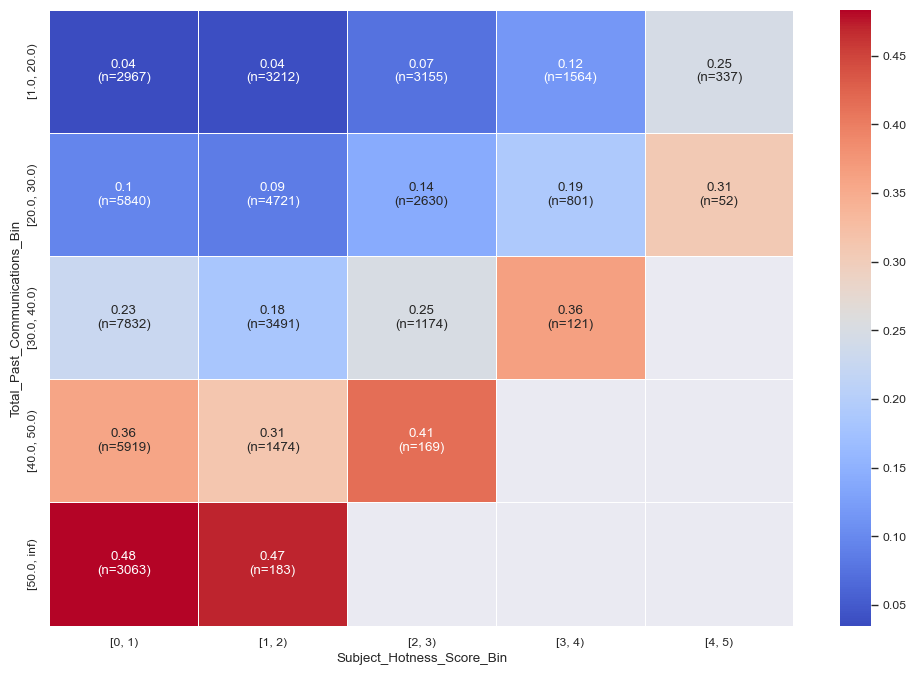

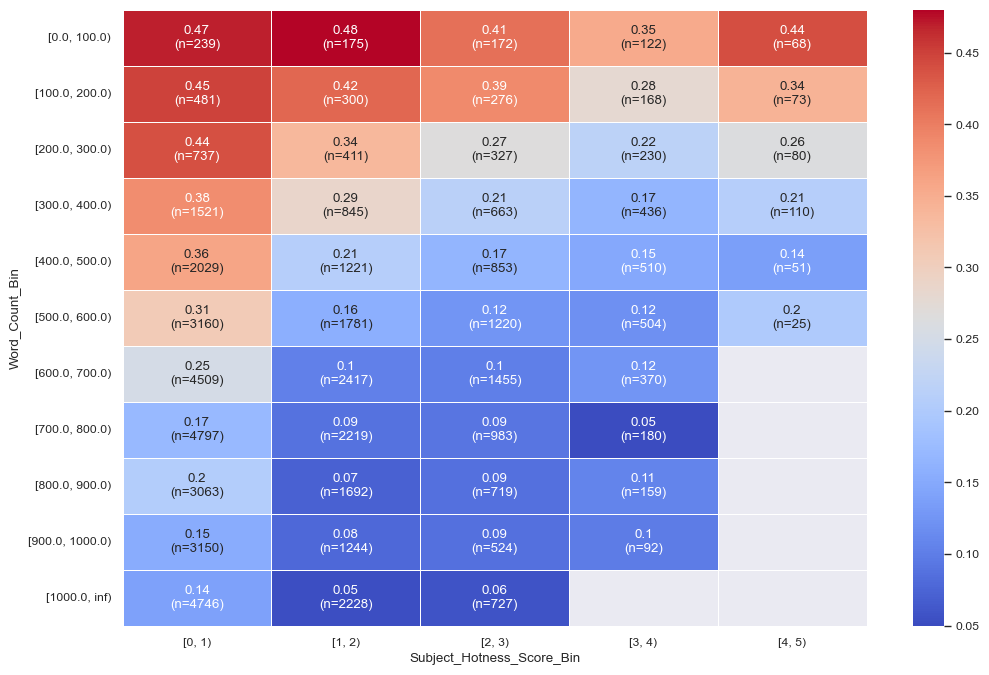

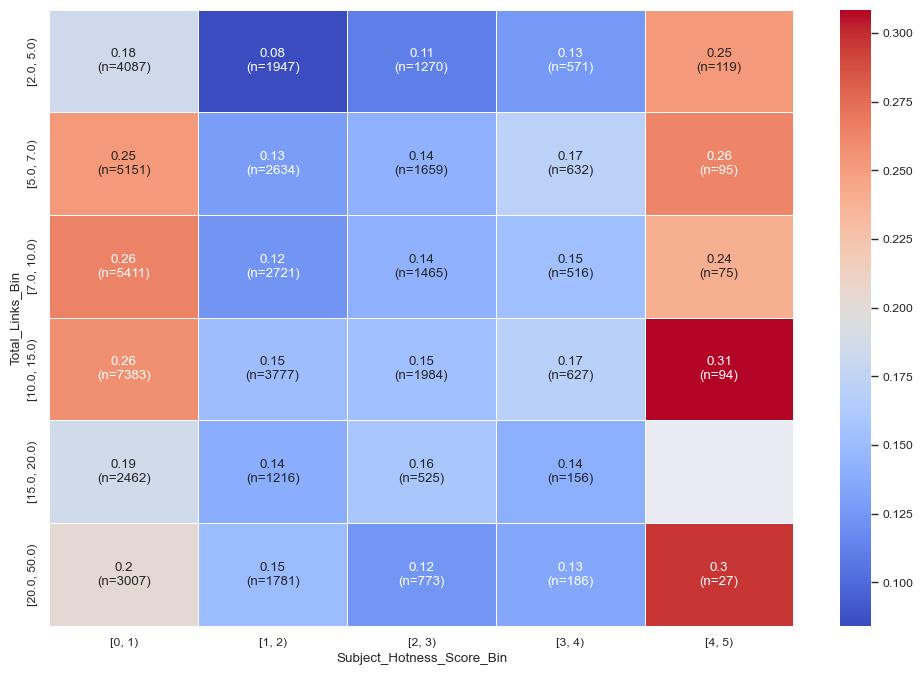

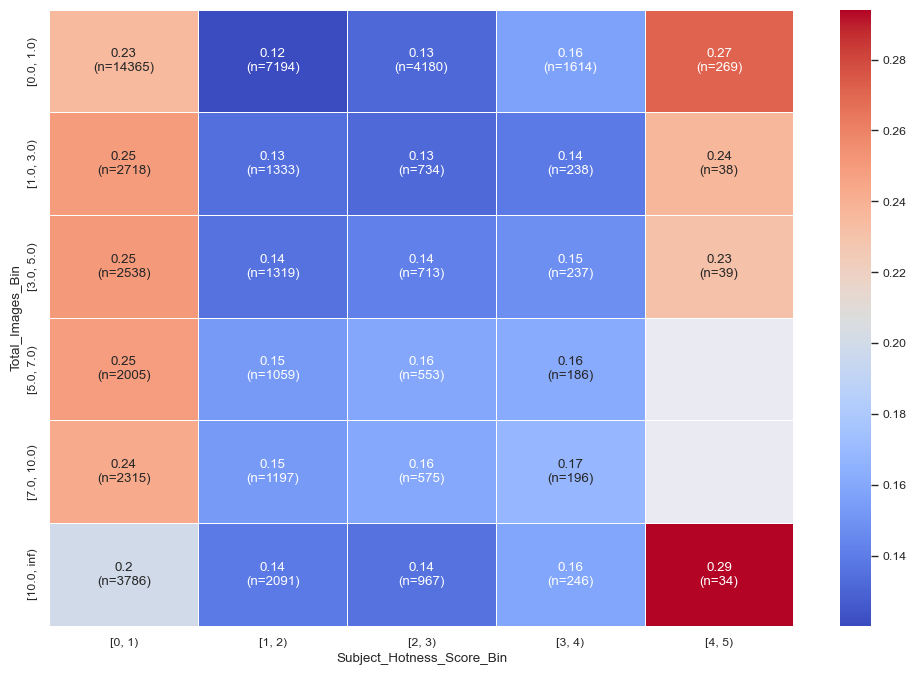

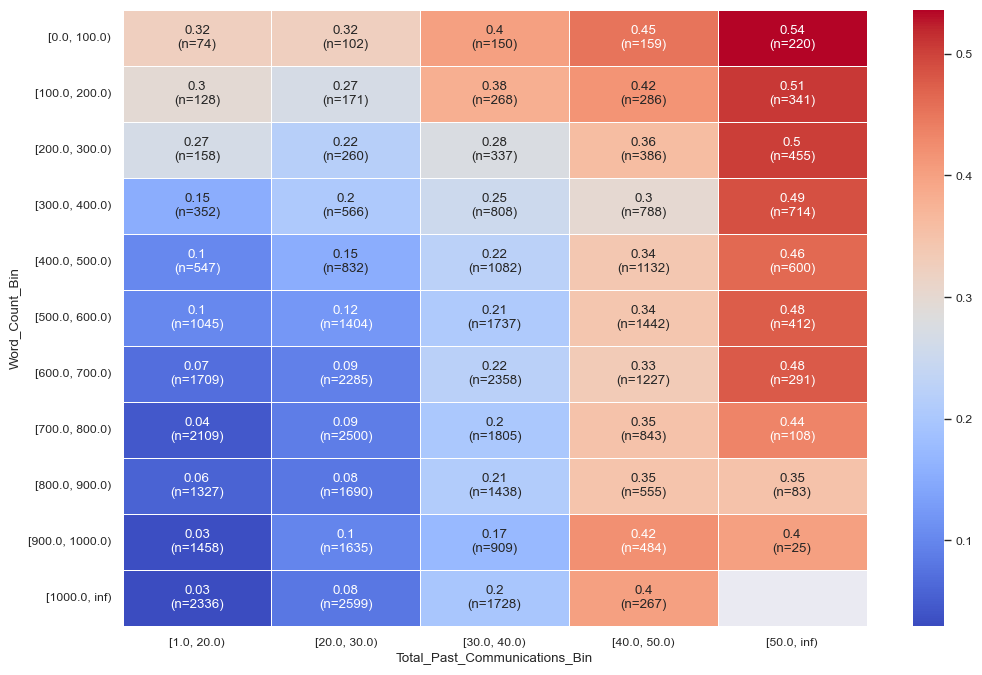

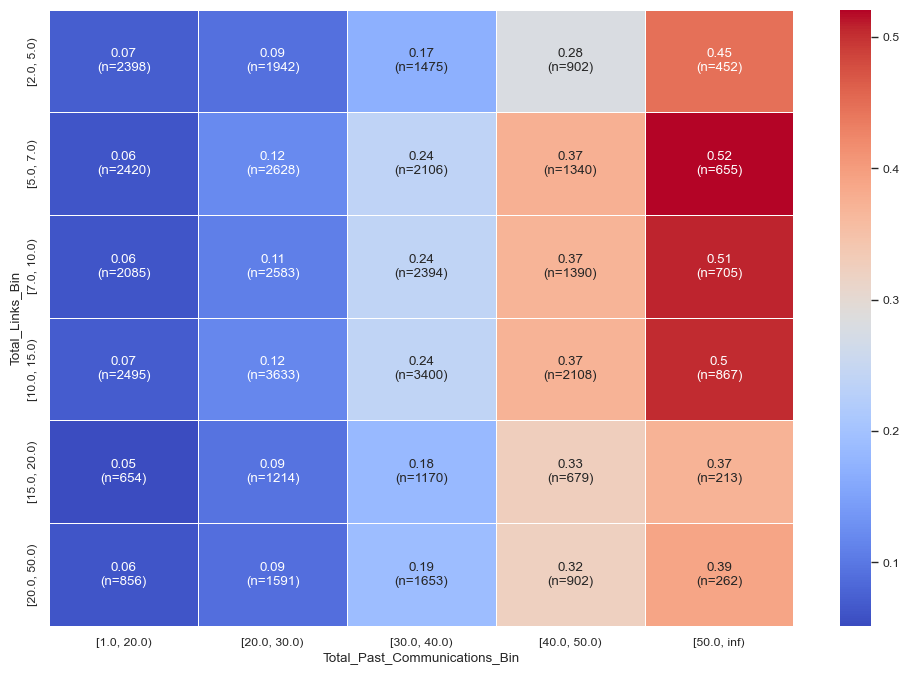

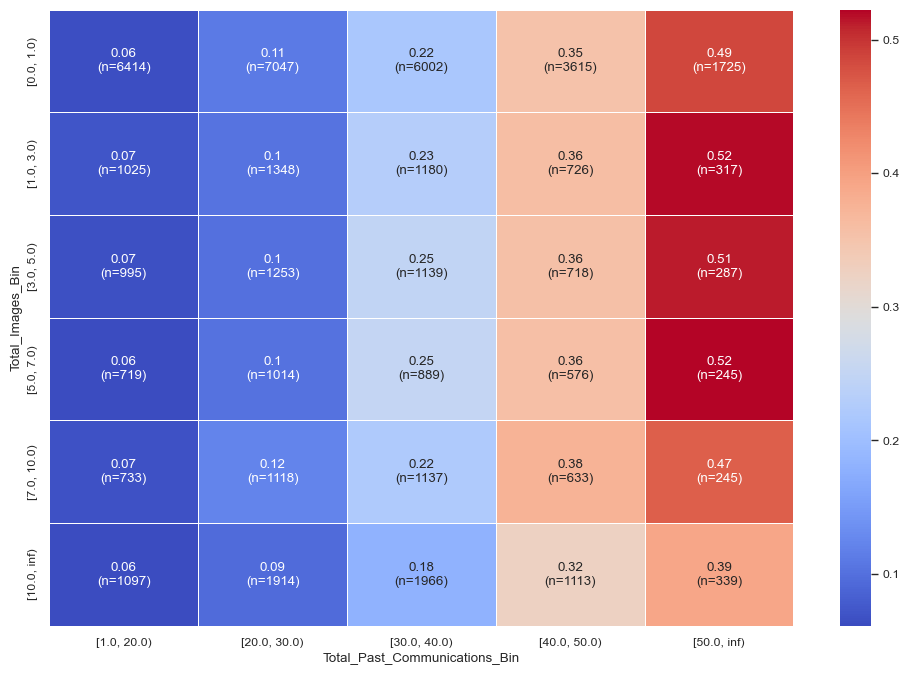

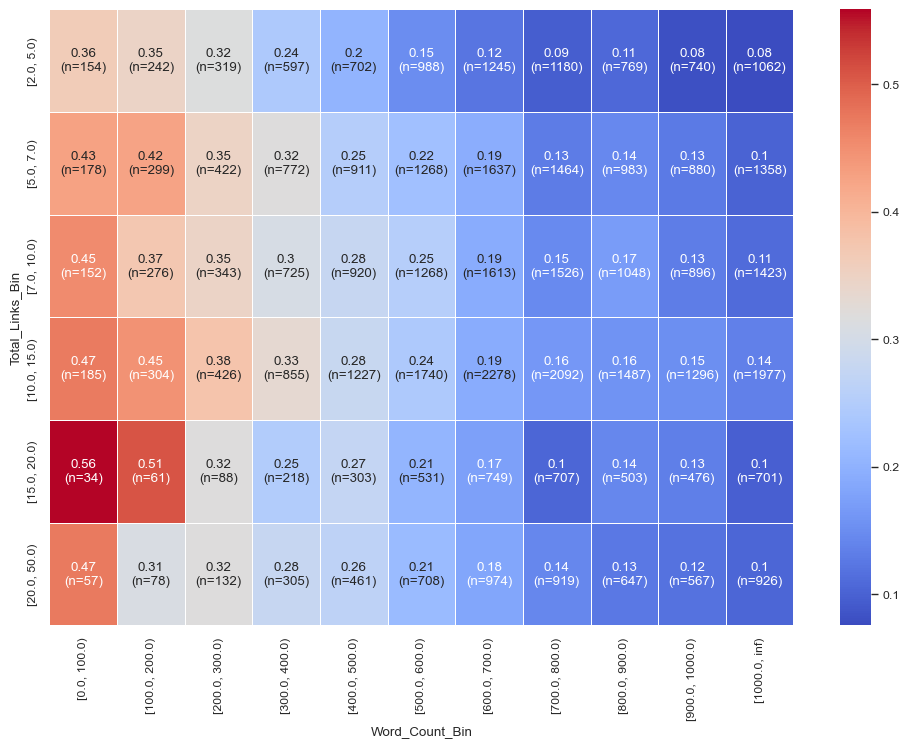

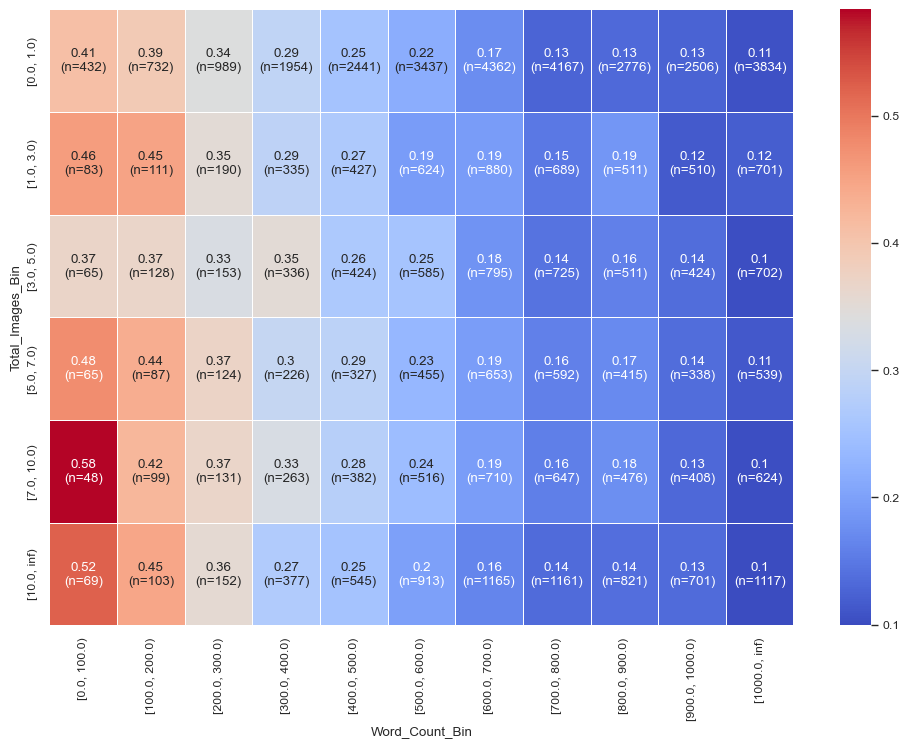

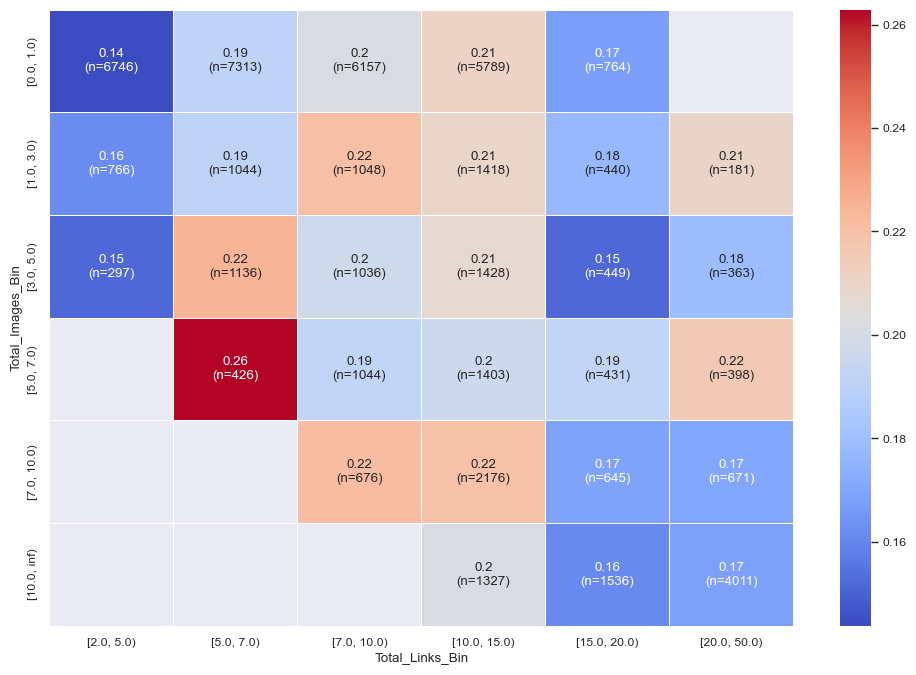

In [66]:
used = []
for key in ['Subject_Hotness_Score_Bin',	'Total_Past_Communications_Bin',	'Word_Count_Bin',	'Total_Links_Bin',	'Total_Images_Bin']:
    used.append(key)
    for key_j in ['Subject_Hotness_Score_Bin',	'Total_Past_Communications_Bin',	'Word_Count_Bin',	'Total_Links_Bin',	'Total_Images_Bin']:
        if (key != key_j) & (key_j not in used):
            bin_prob_heatmap(XY_train[XY_train["Email_Campaign_Type"] != 1], key, key_j)

## Click Rate & Categorical features
* Many of these categoricals seem to have evenly distributed probabilities across labels. 
    * However, we see big differences based on the campaign type: 1 and 3 have a higher representation of clicked emails than 2. 3 is a very small group though.

In [73]:
cat_feat_df = XY_train[["Email_Type","Email_Source_Type","Customer_Location","Email_Campaign_Type","Time_Email_sent_Category","Email_Status"]].copy()

In [1099]:
def calc_prob_success(df, cat_feature, target):
   
    prob_table = df.groupby(cat_feature,observed=True).agg(
        probability_of_success=(target, 'mean'),
        sample_size=(target, 'size')
    ).reset_index()
    
    # Rename the columns for clarity
    prob_table.columns = [cat_feature, 'probability_of_success', 'sample_size']
    
    # Create the bar plot with sample sizes
    g = sns.catplot(prob_table, x=cat_feature, y='probability_of_success', kind='bar', aspect=1.5)
    
    # Add sample size annotations
    for i, row in prob_table.iterrows():
        g.ax.text(i, row['probability_of_success'] + 0.01, f'n={row["sample_size"]}', 
                  ha='center', va='bottom', fontsize=10, color='black')
    # plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()
    
    return prob_table

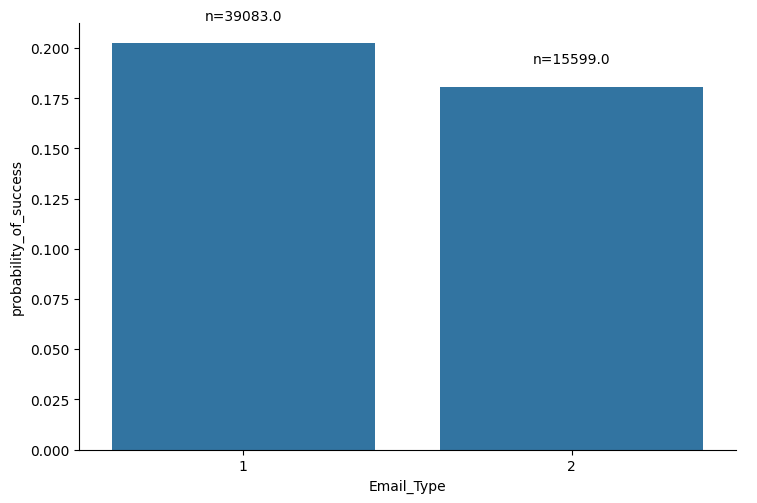

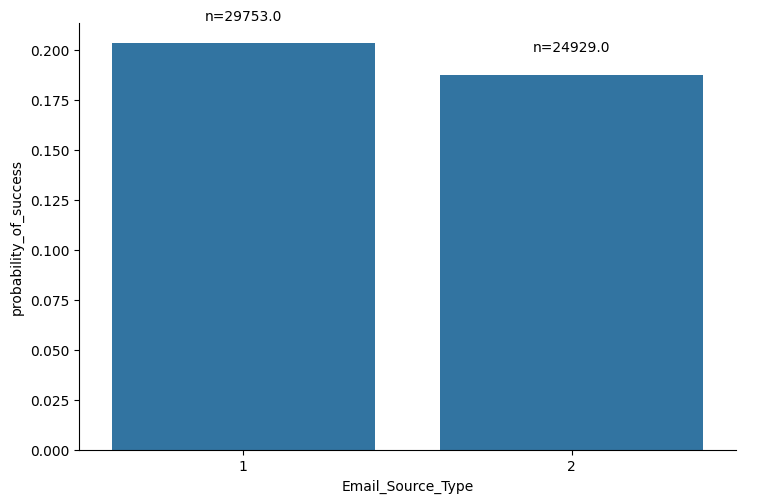

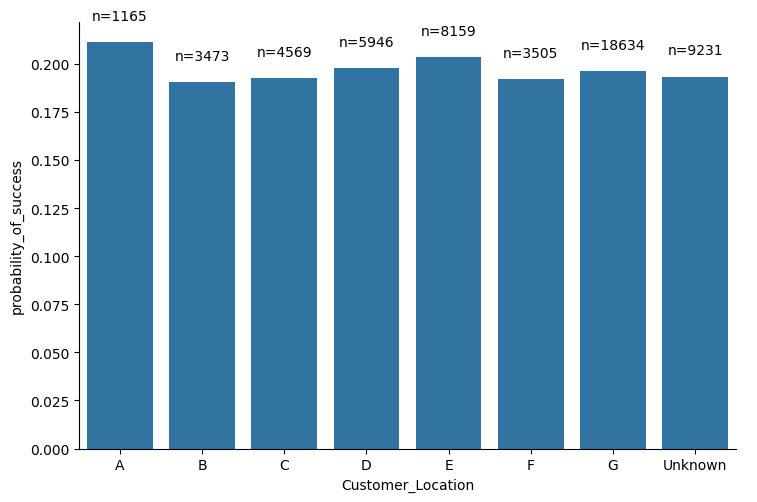

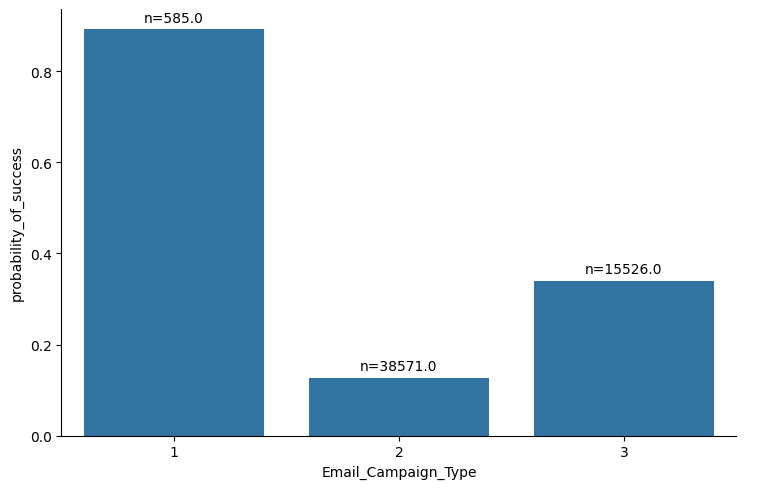

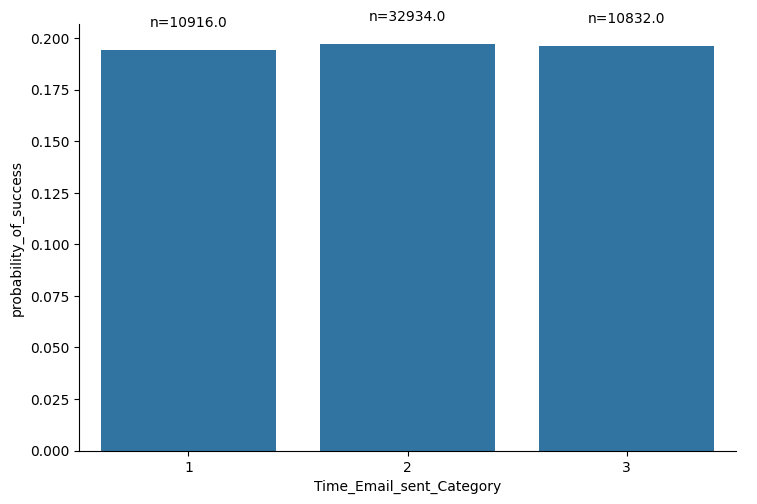

In [1100]:
for i in cat_feat_df.columns[:-1]:

    calc_prob_success(XY_train,i,"Email_Status")

## Click Rate and Interactive Categorial Features

Let's look at the probability of clicking across combinations of categoricals 
* Does not seem like there is much interaction between categoricals. The campaign type is the only thing that really causes differences in this view.


In [84]:
def cat_prob_heatmap(df, cat_x, cat_y, target_col, cmap="coolwarm", min_sample_threshold=5, vmin=0, vmax=1, alpha_weighting=True):
    # Compute probability and sample size for each category pair
    grouped = df.groupby([cat_y, cat_x], observed=True)
    prob_matrix = grouped[target_col].mean().unstack()
    count_matrix = grouped.size().unstack().fillna(0).astype(int)  # Sample sizes

    # Create annotation text in "probability (n=sample_size)" format
    annot_text = prob_matrix.round(2).astype(str) + "\n(n=" + count_matrix.astype(str) + ")"

    # Mask low sample size bins
    mask = count_matrix < min_sample_threshold

    # Adjust alpha (transparency) based on sample size
    if alpha_weighting:
        alpha = count_matrix / count_matrix.max()  # Normalize between 0 and 1
        alpha = np.clip(alpha, 0.3, 1)  # Avoid complete fading

    # Plot heatmap with fixed color scale
    plt.figure(figsize=(11, 5))
    ax = sns.heatmap(
        prob_matrix,
        annot=annot_text,
        fmt="",
        cmap=cmap,
        cbar=True,
        mask=mask,
        linewidths=0.5,
        vmin=vmin,  # Fix color scale to avoid small differences looking extreme
        vmax=vmax
    )

    # Apply transparency based on sample size (if enabled)
    if alpha_weighting:
        for i, text in enumerate(ax.texts):
            row, col = divmod(i, prob_matrix.shape[1])
            text.set_alpha(alpha.iloc[row, col])  # Adjust transparency per sample size

    plt.xlabel(cat_x)
    plt.ylabel(cat_y)
    plt.title(f"Probability Heatmap of {target_col} (Categorical, Adjusted)")
    plt.show()

    return prob_matrix, count_matrix


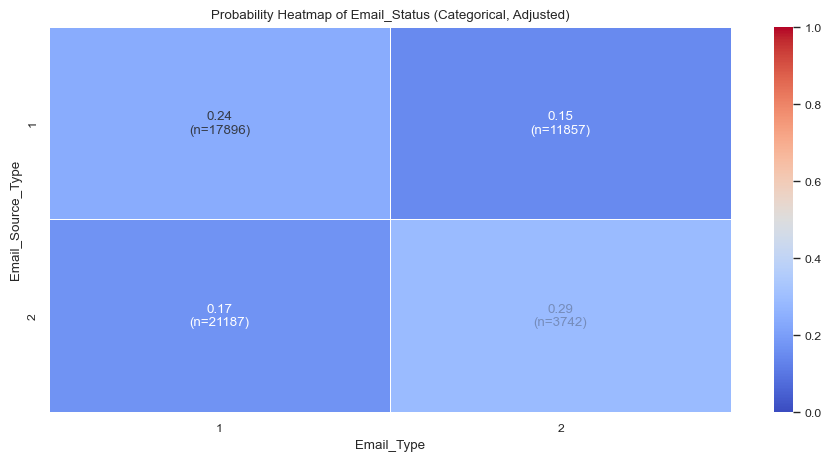

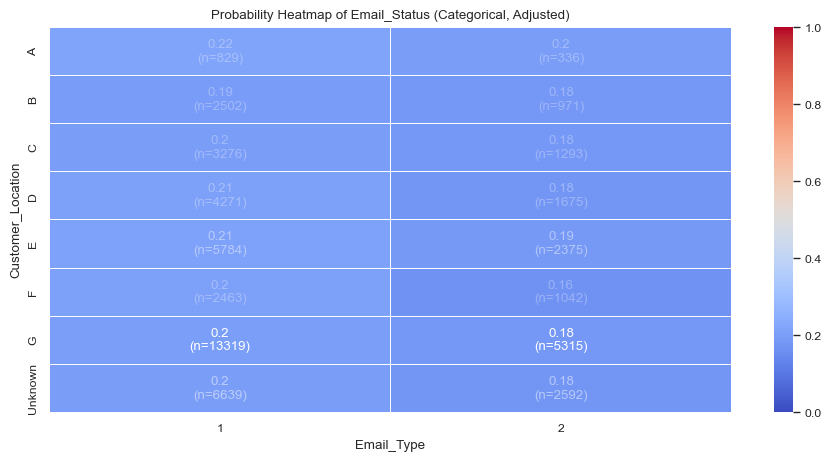

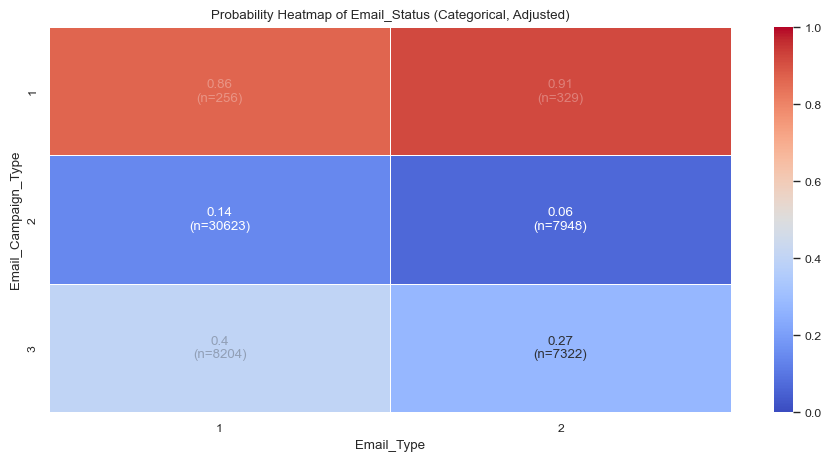

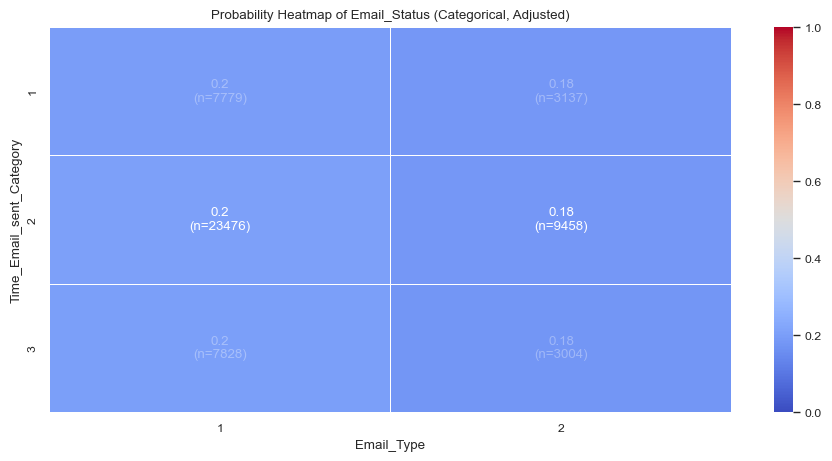

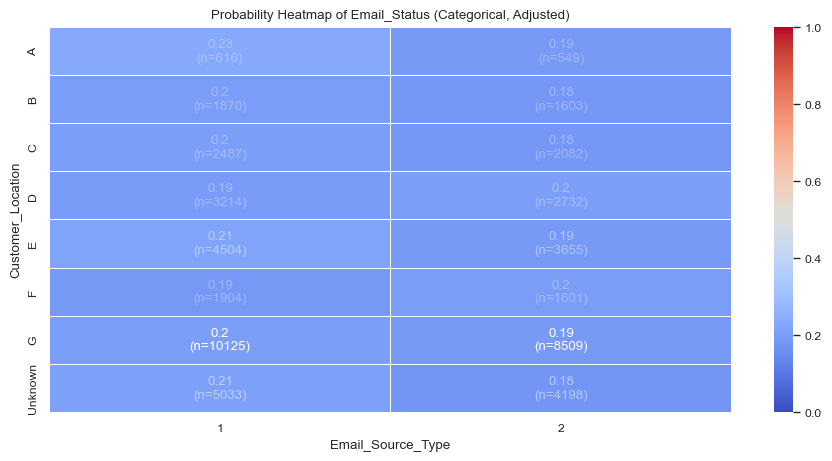

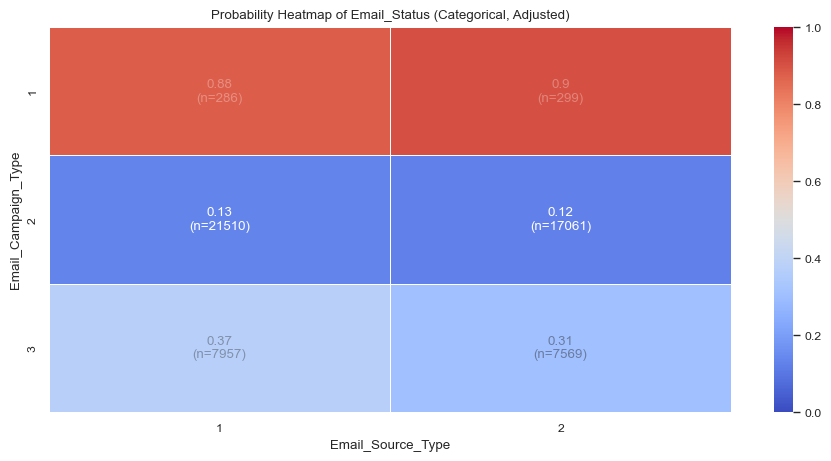

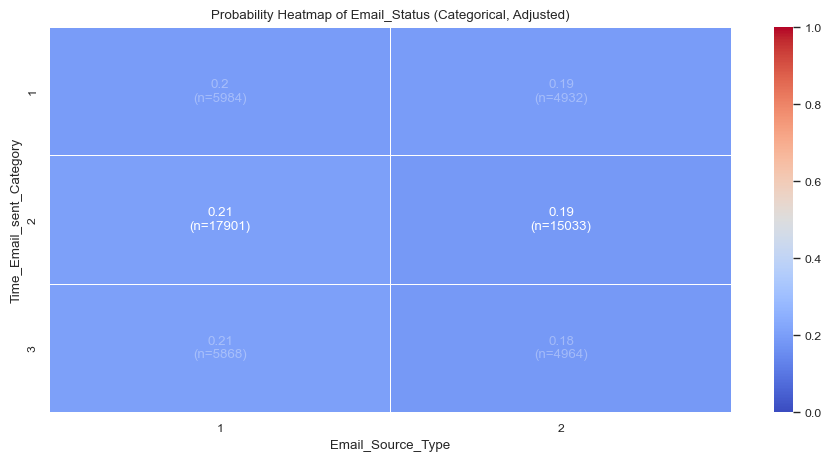

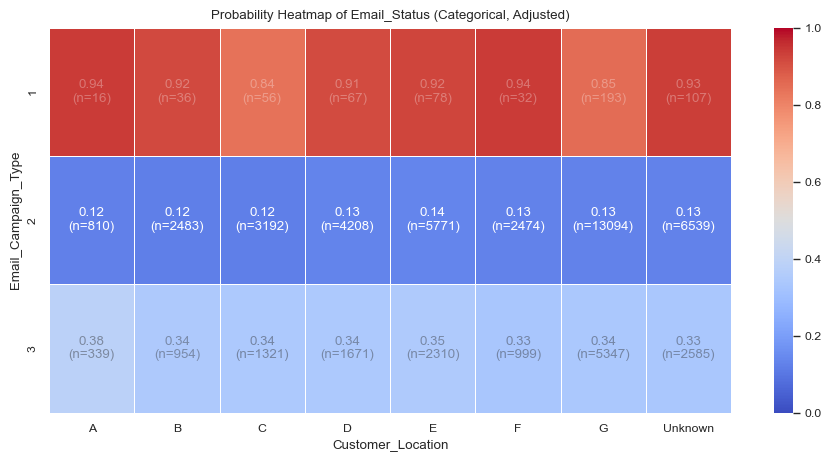

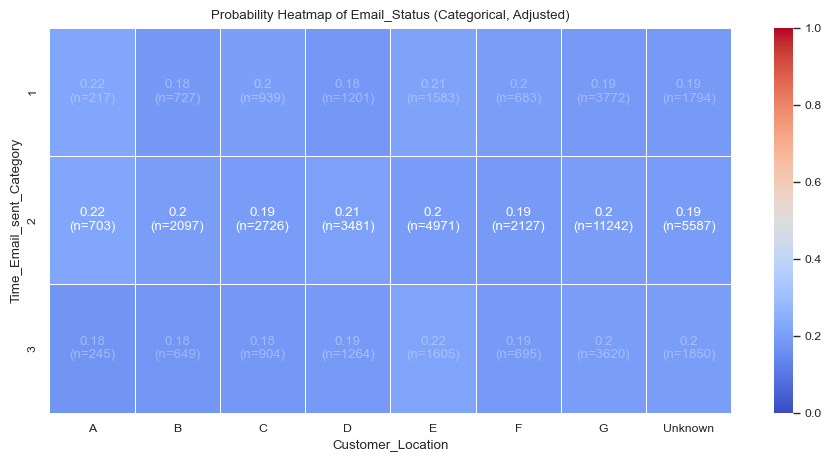

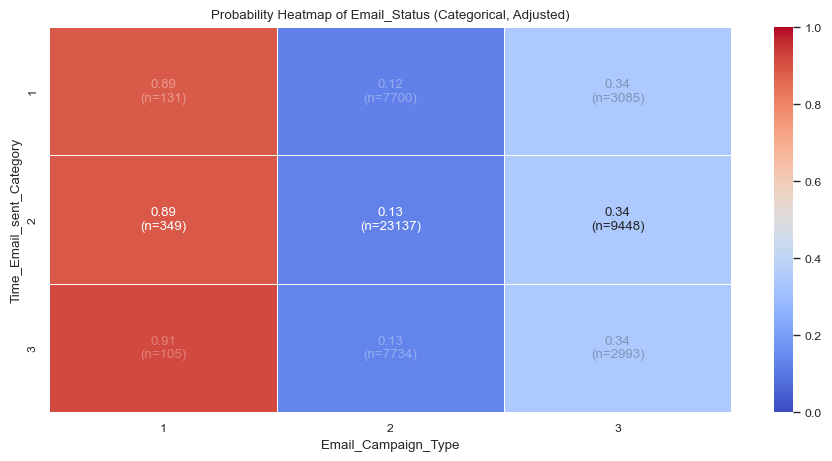

In [85]:
used = []
for i in cat_feat_df.columns[:-1]:
    used.append(i)
    for j in cat_feat_df.columns[:-1]:
        if (i != j) & (j not in used):
            cat_prob_heatmap(XY_train, cat_x = i, cat_y = j, target_col="Email_Status", cmap="coolwarm", min_sample_threshold=5)

## Numeric and Categorical feature interaction to predict click-decision

Let's now see how probabilities change across bins of numerics and labels of categoricals. Categoricals on their own was a bit of a dud outside of the campaign type, but maybe crossing over with numerics will show something.

* `Email_Campaign_Type`
    * Very important to note here that campaigns 1 and 3 are made up of only one single type of `Subject_Hotness_Score` (<1)! We can account for this before modeling during feature selection.
    * More on Campaign 3:
        * Made up entirely of new recepients (`Total_Past_Communications` = 0)
        * Only has 1 `Total_Link` and 1 `Total_Image`
        * Only in [0, 1) subject hotness bin
        * Completely insensitive to word counts, which is not true for any other cohort.
    * Campaign 2 strong interaction with multiple numeric features. Lots of signal.
        * Subject hotness - hotter = better
        * Word Count - fewer better
* `Subject Hotness` and `Past Communication`
    * More communication lessens sensitivity to hotness score
* `Past Communication` and `Word Count`
    * Very strong interaction here with large subset. Destined to be a powerful predicter. More Communication + Less words == lots of clicks


In [74]:
def cat_num_prob_heatmap(df, cat_col, num_col, cmap="coolwarm", min_sample_threshold=0, vmin=0, vmax=1, alpha_weighting=True):
        # Compute probability and sample size for each category-bin pair
    grouped = df.groupby([num_col,cat_col],observed=True)
    prob_matrix = grouped["Email_Status"].mean().unstack()
    count_matrix = grouped.size().unstack().fillna(0).astype(int)  # Sample sizes

    # Create annotation text in "probability (n=sample_size)" format
    annot_text = prob_matrix.round(2).astype(str) + "\n(n=" + count_matrix.astype(str) + ")"

    # Mask low sample size bins
    mask = count_matrix < min_sample_threshold

    # Adjust alpha (transparency) based on sample size
    if alpha_weighting:
        alpha = count_matrix / count_matrix.max()  # Normalize between 0 and 1
        alpha = np.clip(alpha, 0.3, 1)  # Avoid complete fading

    # Plot heatmap with fixed color scale
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
        prob_matrix,
        annot=annot_text,
        fmt="",
        cmap=cmap,
        cbar=True,
        mask=mask,
        linewidths=0.5,
        # vmin=vmin,  # Fix color scale to avoid small differences looking extreme
        # vmax=vmax
    )

    # Apply transparency based on sample size (if enabled)
    if alpha_weighting:
        for i, text in enumerate(ax.texts):
            row, col = divmod(i, prob_matrix.shape[1])
            text.set_alpha(alpha.iloc[row, col])  # Adjust transparency per sample size

    plt.ylabel(num_col)
    plt.xlabel(cat_col)
    # plt.title(f"Probability Heatmap of {target_col} (Categorical vs Numerical)")
    plt.show()

    return prob_matrix, count_matrix

In [75]:
XY_train[(XY_train["Total_Past_Communications"] <= 30) & (XY_train["Word_Count"] >= 600) & (XY_train["Email_Status"] == 1)].shape

(1926, 16)

Again filter out Campaign 1 because they always do well and it screws up visualizations

In [78]:
cat_feat_df.columns[:-1]

Index(['Email_Type', 'Email_Source_Type', 'Customer_Location',
       'Email_Campaign_Type', 'Time_Email_sent_Category'],
      dtype='object')

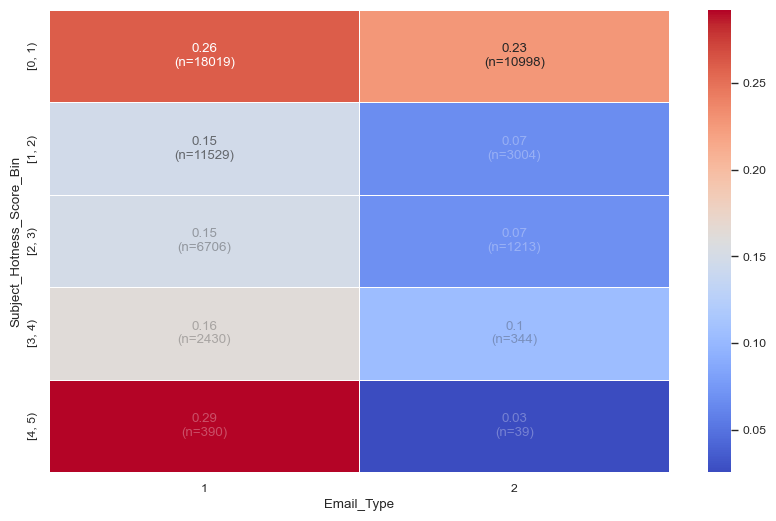

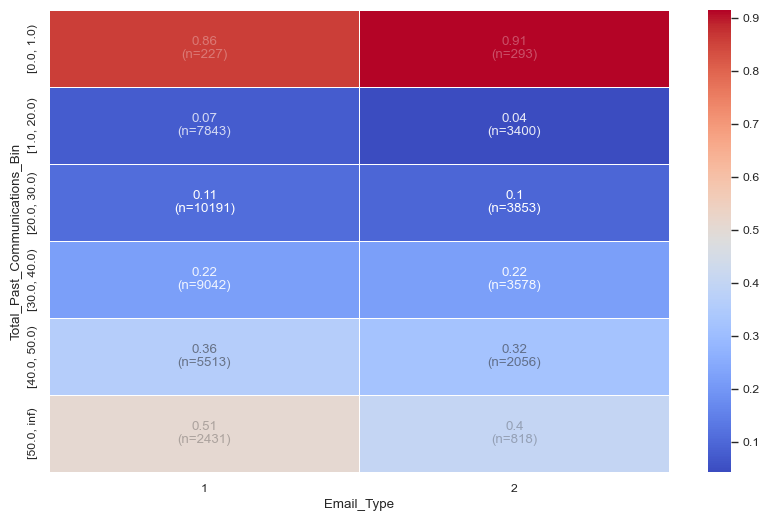

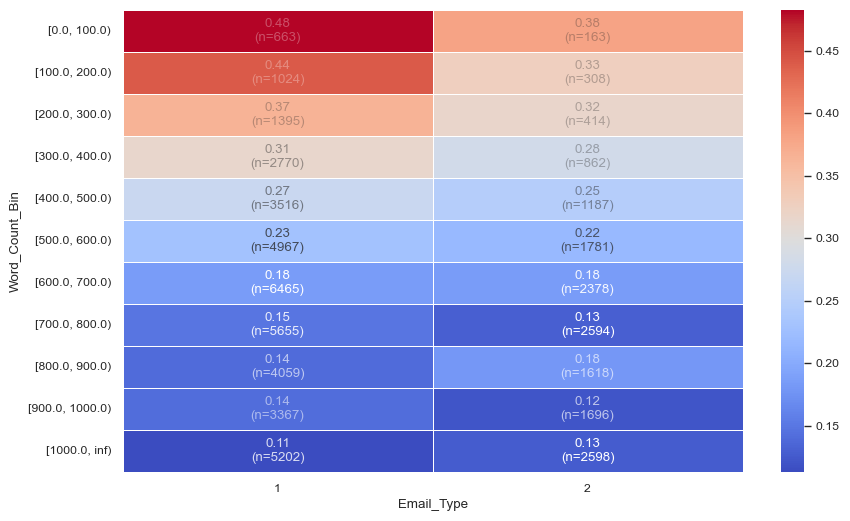

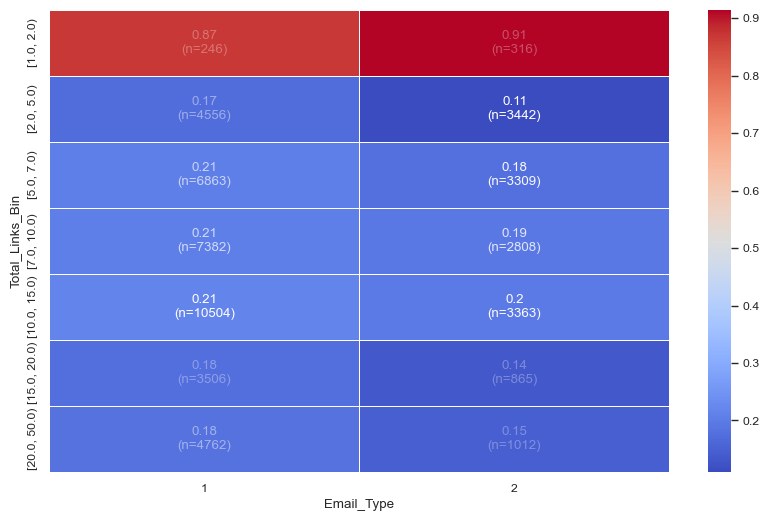

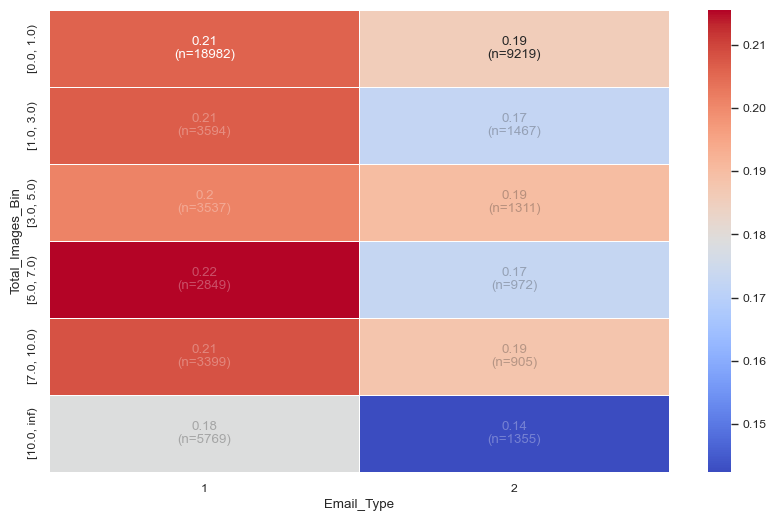

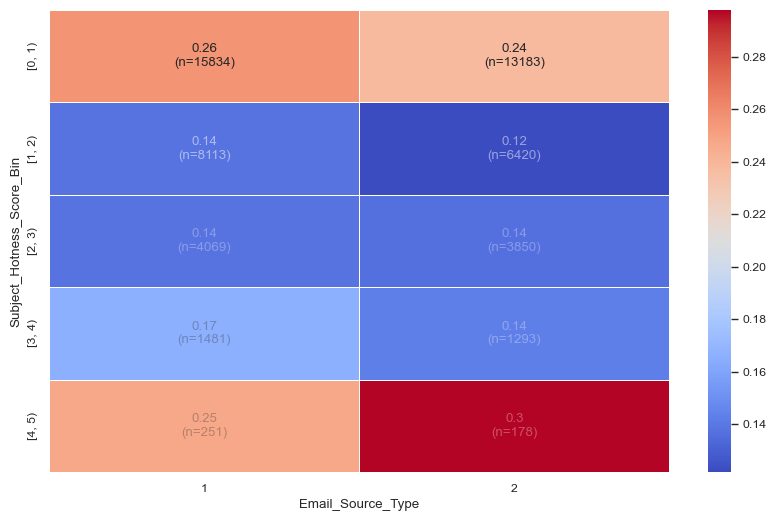

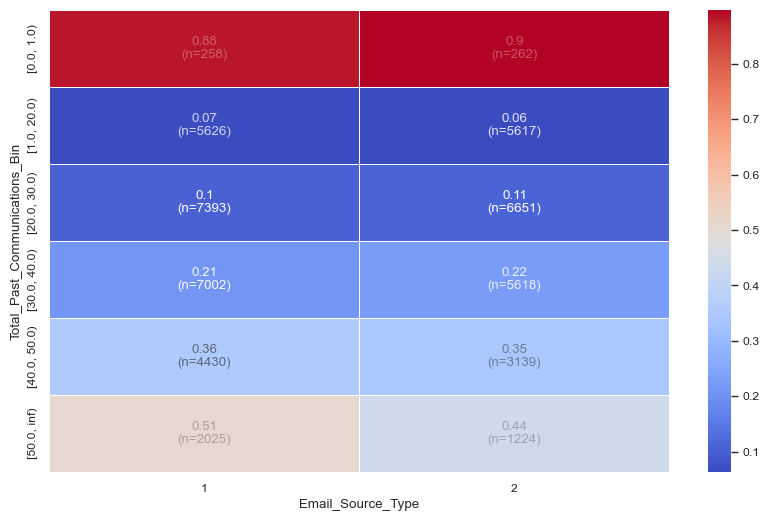

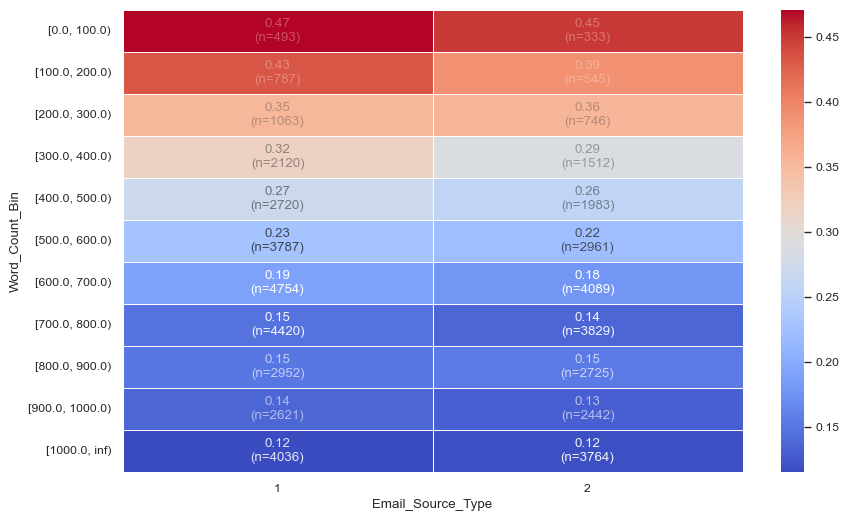

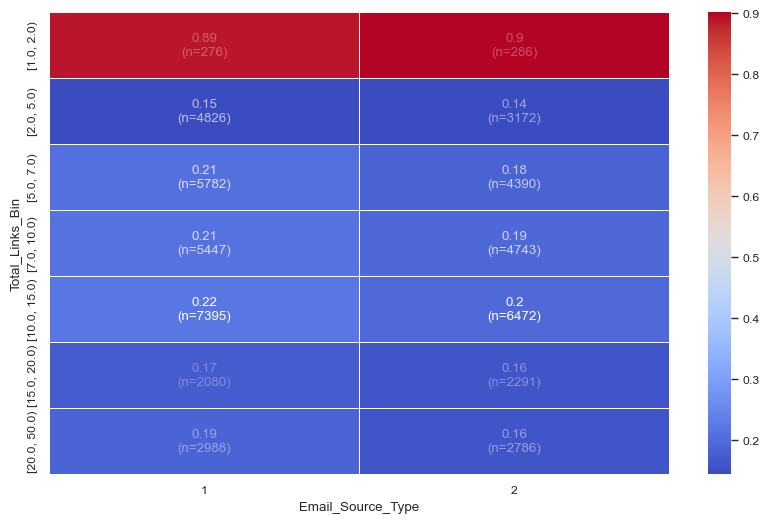

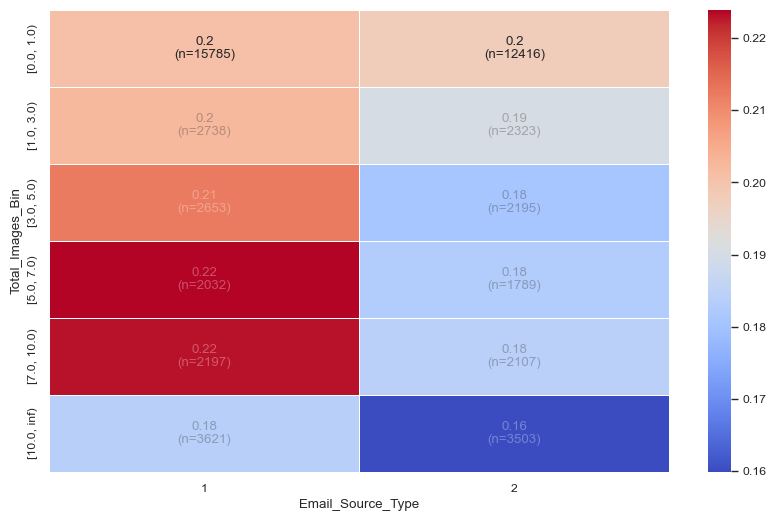

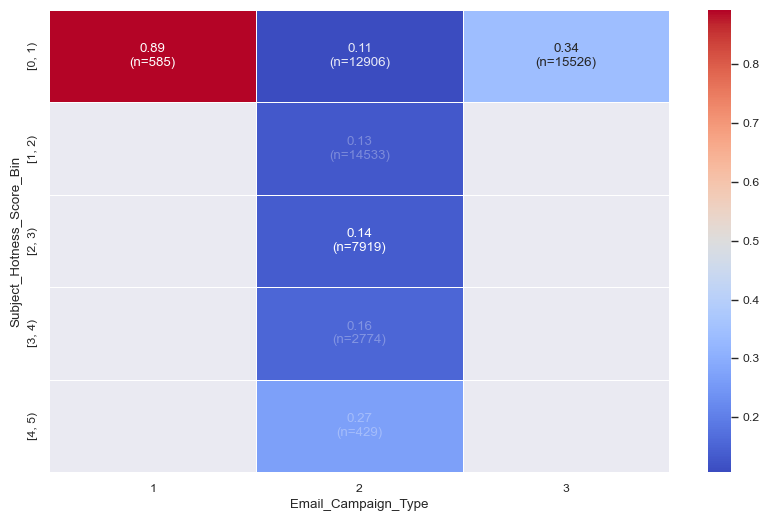

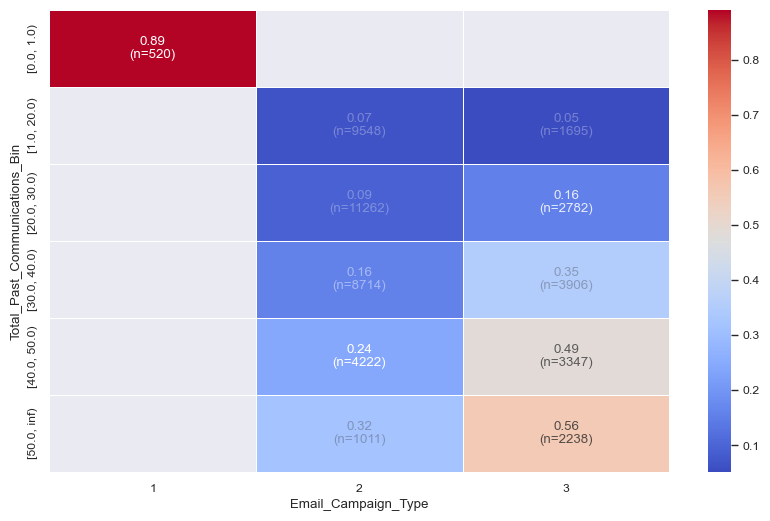

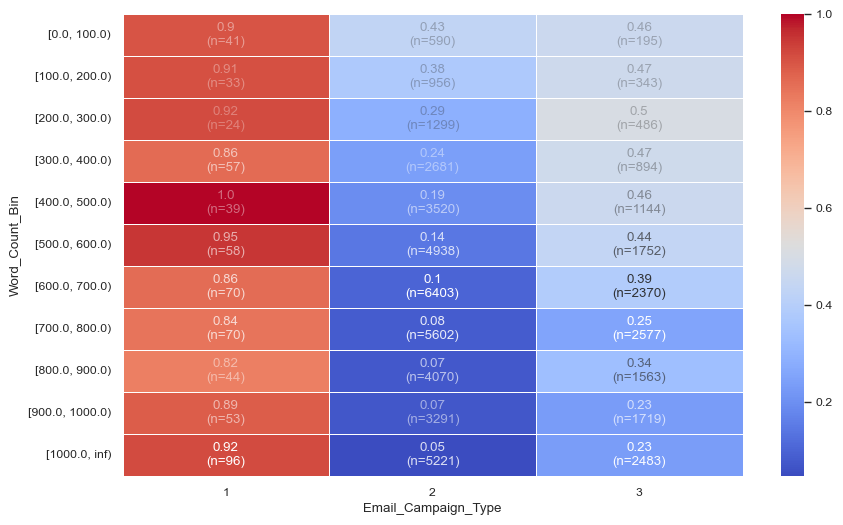

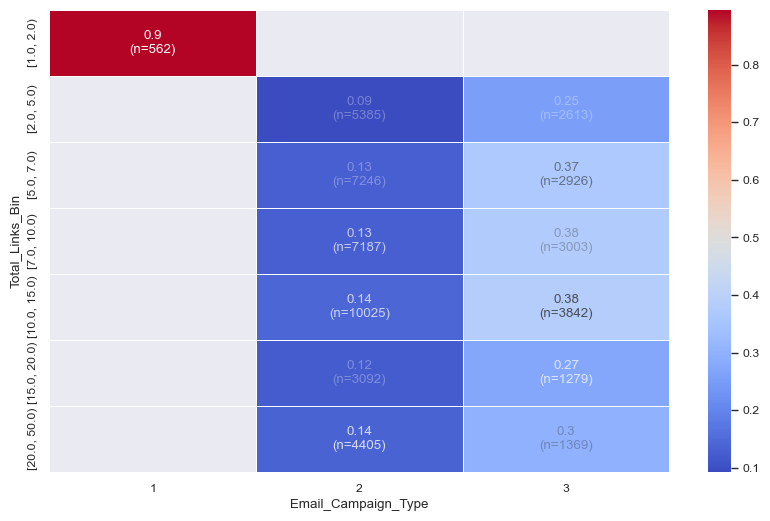

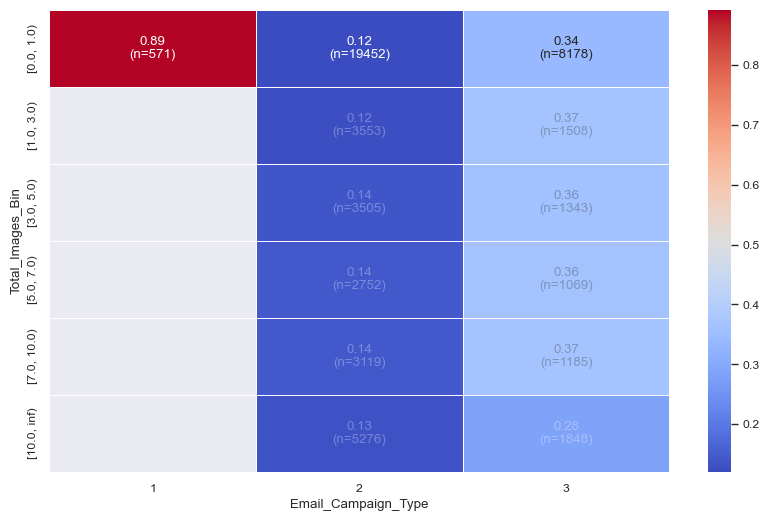

In [82]:
for i in ['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type']:
    for j in ['Subject_Hotness_Score_Bin',	'Total_Past_Communications_Bin',	'Word_Count_Bin',	'Total_Links_Bin',	'Total_Images_Bin']:
        cat_num_prob_heatmap(XY_train, i, j) #[XY_train["Email_Campaign_Type"] != 1]

## Data Transformations
I will adjust the skewed distributions and revisualize. Depending on the data type/distribution a different transformation may be more appropriate. In the ML notebook we will build these into a pipeline. It is worth noting that transformations are only necessary for linear models. So when modeling we won't worry about this for tree based models. It is moreso for when we try baseline linear models like logistic regression.
* Subject Hotness Score
    * Yeo Johnson would be an appropriate transformation since it is right skewed and approximately continuous
* Total Past Communications and Word Count do not need to be transformed as these are approximately normally distributed
* Total Links and Total Images are right skewed and since they are 'count' data it may make more sense to use sqrt() transformations to fix the skew and stabilize the variance
    * Worth noting that Total Images are very 0-count heavy. So a transformation here is not likely to produce a normal distribution.

In [648]:
XY_train["YJ_Subject_Hotness_Score"], _ = stats.yeojohnson(XY_train["Subject_Hotness_Score"])
XY_train["Sqrt_Total_Images"] = np.sqrt(XY_train["Total_Images"])
XY_train["Sqrt_Total_Links"] = np.sqrt(XY_train["Total_Links"])

After the transformations, we can observe the following:
* Total Links does appear to be approx normal
* Hotness score and Total Images still do not follow a normal distribution, they are bimodal, which could be an issue for linear models. 
    * To try to overcome this, we can bin them using some heuristic approach such as hotness <1 and >=1 and total images =0 and >0. We will try to use them as is first, though.

In [ ]:
for i in ['YJ_Subject_Hotness_Score','Total_Past_Communications','Word_Count','Sqrt_Total_Links','Sqrt_Total_Images']:
    sns.displot(data=XY_train,x=XY_train[i],col='Email_Status',bins = 15,facet_kws={'sharey':False})

# sns.pairplot(XY_train[['YJ_Subject_Hotness_Score','Total_Past_Communications','Word_Count','Sqrt_Total_Links','Sqrt_Total_Images','Email_Status']].sample(15000),plot_kws={'alpha':.05},hue="Email_Status", corner=True)

## Outlier detection and handling
Outliers aren't a big issue for most features. Links and Images have several, with the latter being most egrigious. Our data transformations described above should help with this issue for linear models. For tree-based models we will bin our counts anyways so outliers won't have an impact.

In [ ]:
for col in num_feat_df.columns:
    print(col)
    dist_df = XY_train[col].describe().round(3).to_frame().T
    print(dist_df)
    outlier = XY_train[col].quantile(.75) + 1.5*(XY_train[col].quantile(.75) - XY_train[col].quantile(.25))
    print("Outlier threshold",outlier.round(1))
    print("Num of Outliers", XY_train[XY_train[col] > outlier].shape[0])
    sns.boxplot(data=XY_train,x=col)
    plt.show()